In [7]:
%matplotlib inline
from re import DEBUG
from turtle import color
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from warnings import simplefilter
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import WindowsPath
import time
from collections import defaultdict
import re
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import datetime
import pickle
from collections import Counter

DEBUGGING: bool = False
NUM_EVENT_PER_POS = 100
MAP_SET_PADS_TO_TRIANGLE = defaultdict(
    int,
    {
        frozenset([6, 5, 4]): 1,
        frozenset([4, 5, 3]): 2,
        frozenset([4, 3, 2]): 3,
        frozenset([3, 2, 1]): 4,
        frozenset([6, 8, 5]): 5,
        frozenset([5, 3, 13]): 6,
        frozenset([3, 13, 1]): 7,
        frozenset([8, 5, 10]): 8,
        frozenset([5, 10, 13]): 9,
        frozenset([13, 1, 14]): 10,
        frozenset([8, 9, 10]): 11,
        frozenset([10, 11, 13]): 12,
        frozenset([11, 13, 14]): 13,
        frozenset([9, 10, 11]): 14,
    },
)
max_num_triangle: int = 14
COL_PADS = np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14])
UNIT_OF_MEASURE_COL = {
    "pmax": "mV",
    "negpmax": "mV",
    "tmax": "ns",
    "area": "mV $\\cdot$ ns",
    "rms": "mV",
}
np.random.seed(12345)


In [2]:
dev_df_proc = pd.read_csv("./development_processed.csv", header=0, index_col=False)
eval_df_processed = pd.read_csv("./evaluation_processed.csv", header = 0, index_col = False)
eval_df_processed.drop(["triangle", "x_triag", "y_triag"], inplace=True, axis = 1)
dev_df_proc_sum = dev_df_proc.copy()
eval_df_processed_sum = eval_df_processed.copy()
dev_df_proc_max = dev_df_proc.copy()
eval_df_processed_max = eval_df_processed.copy()
dev_df_proc_sum["sumpmax"] = dev_df_proc[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].sum(axis = 1)
eval_df_processed_sum["sumpmax"] = eval_df_processed[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].sum(axis = 1)

for pad in COL_PADS:
    dev_df_proc_sum[f"norm_pmax[{pad}]"]=dev_df_proc[f"pmax[{pad}]"]/dev_df_proc_sum["sumpmax"]
    eval_df_processed_sum[f"norm_pmax[{pad}]"]=eval_df_processed[f"pmax[{pad}]"]/eval_df_processed_sum["sumpmax"]
    
dev_df_proc_sum.drop("sumpmax", axis = 1, inplace=True)
eval_df_processed_sum.drop("sumpmax", axis = 1, inplace=True)



dev_df_proc_max["maxpmax"] = dev_df_proc[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].max(axis = 1)
eval_df_processed_max["maxpmax"] = eval_df_processed[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].max(axis = 1)

for pad in COL_PADS:
    dev_df_proc_max[f"norm_pmax[{pad}]"]=dev_df_proc[f"pmax[{pad}]"]/dev_df_proc_max["maxpmax"]
    eval_df_processed_max[f"norm_pmax[{pad}]"]=eval_df_processed[f"pmax[{pad}]"]/eval_df_processed_max["maxpmax"]
    
dev_df_proc_max.drop("maxpmax", axis = 1, inplace=True)
eval_df_processed_max.drop("maxpmax", axis = 1, inplace=True)

In [3]:
def test_train_set_points_div(data: pd.DataFrame, ratio_train: float = 0.8)->tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    step = int(1 / ratio_train)
    if NUM_EVENT_PER_POS % step != 0:
        raise ValueError(
            f"int(1/ratio_train) has to be a submultiple of a {NUM_EVENT_PER_POS}"
        )   
    coords = data.groupby(['x','y']).size().reset_index()
    coords = coords[["x", "y"]].drop_duplicates()    
    coords_train = coords.sample(frac=ratio_train, random_state=12345)  
    coords_test_index = coords.index.difference(coords_train.index)
    coords_test = coords.loc[coords_test_index, :]
    train_dataset = pd.merge(coords_train, data,  on=["x", "y"])
    test_dataset = pd.merge(coords_test, data,  on=["x", "y"])
    
    print(data.shape)
    print(train_dataset.shape)
    print(test_dataset.shape)
        
    return (train_dataset, test_dataset)

    
    

(385500, 39)
(308400, 39)
(77100, 39)


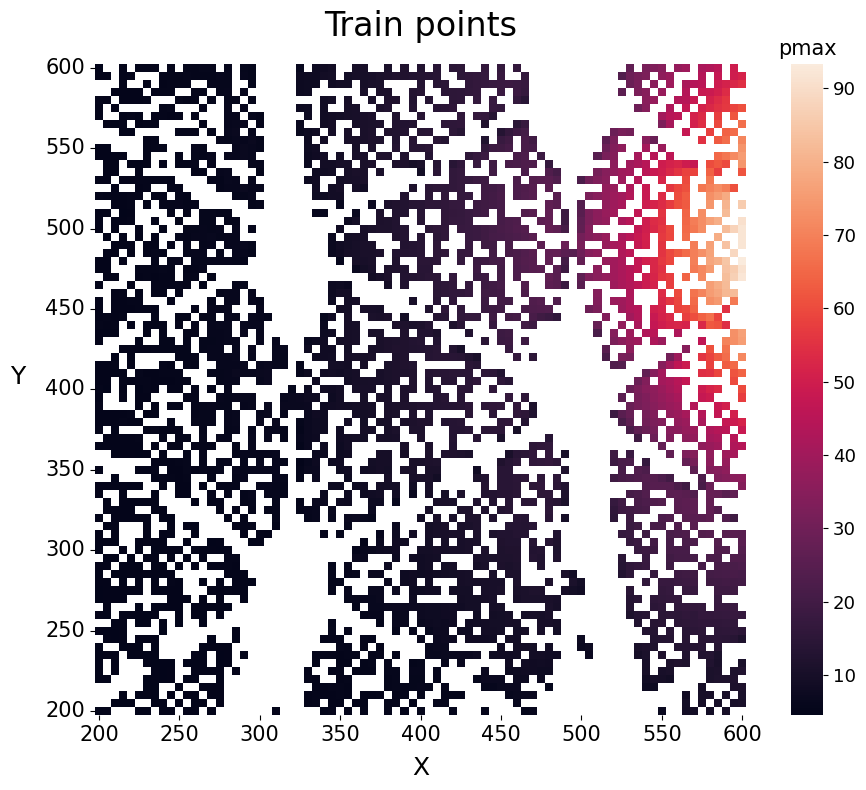

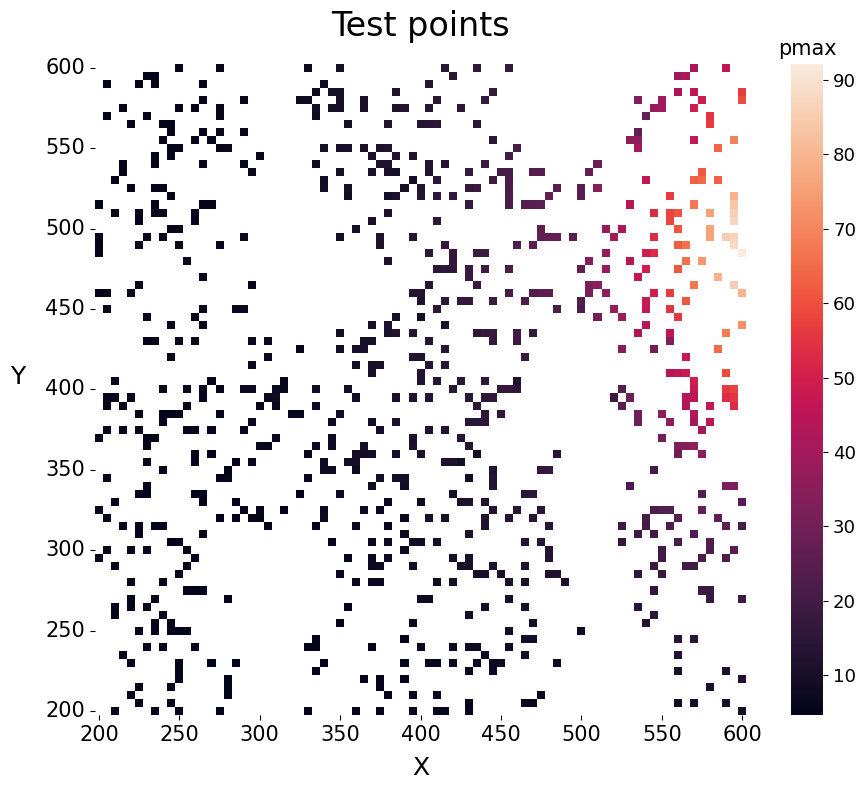

In [4]:
def personalize_heatmap(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    title_colorbar: str,
    xlabel: str,
    ylabel: str,
) -> None:
    fig.set_size_inches(10, 8)

    color_bar = ax.collections[0].colorbar
    color_bar.ax.set_title(title_colorbar, fontsize=15)
    color_bar.ax.tick_params(axis="both", which="major", labelsize=13)
    color_bar.ax.tick_params(axis="both", which="minor", labelsize=13)
    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0)
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=20.0)
    col_labels = [int(col) for col in data_heatmap.columns]
    row_labels = [int(col) for col in data_heatmap.index]
    step = 10
    ax.set_xticks(
        np.arange(start=0.5, stop=data_heatmap.index.size, step=step),
        labels=col_labels[::step],
        fontsize=15,
    )
    ax.set_yticks(
        np.arange(start=0.5, stop=data_heatmap.index.size, step=step),
        labels=row_labels[::step],
        fontsize=15,
    )
    ax.tick_params(axis="x", labelrotation=0)

    plt.tight_layout()



train_dataset, test_dataset = test_train_set_points_div(dev_df_proc)
y_train = train_dataset[["x", "y"]]
X_train = train_dataset.drop(["x", "y"], axis=1)
y_test = test_dataset[["x", "y"]]
X_test = test_dataset.drop(["x", "y"], axis=1)

col = 1
name_col = f"pmax[{col}]"
df_plot = train_dataset[["x", "y", name_col]]
data_heatmap = (
    df_plot.groupby(["x", "y"])
    .mean()
    .reset_index()
    .sort_values(by=["x", "y"], ascending=[True, False])
    .pivot(index="y", columns="x", values=name_col)
    .sort_index(ascending=False)
)
fig, ax = plt.subplots(1, 1)
plot = sns.heatmap(
    data_heatmap,
    ax=ax,
    square=True,
    cbar_kws={"location": "right"},
)
personalize_heatmap(
    ax,
    fig,
    data_heatmap,
    title="Train points",
    title_colorbar="pmax",
    xlabel="X",
    ylabel="Y",
)
plt.show()



col = 1
name_col = f"pmax[{col}]"
df_plot = test_dataset[["x", "y", name_col]]
data_heatmap = (
    df_plot.groupby(["x", "y"])
    .mean()
    .reset_index()
    .sort_values(by=["x", "y"], ascending=[True, False])
    .pivot(index="y", columns="x", values=name_col)
    .sort_index(ascending=False)
)
fig, ax = plt.subplots(1, 1)
plot = sns.heatmap(
    data_heatmap,
    ax=ax,
    square=True,
    cbar_kws={"location": "right"},
)
personalize_heatmap(
    ax,
    fig,
    data_heatmap,
    title="Test points",
    title_colorbar="pmax",
    xlabel="X",
    ylabel="Y",
)
plt.show()

In [5]:
dev_df_proc_max["maxpmax"] = dev_df_proc[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].max(axis = 1)

for pad in COL_PADS:
    dev_df_proc_max[f"norm_pmax[{pad}]"]=dev_df_proc[f"pmax[{pad}]"]/dev_df_proc_max["maxpmax"]
    
dev_df_proc_max.drop("maxpmax", axis = 1, inplace=True)

In [54]:
#train_dataset, test_dataset = test_train_set_points_div(dev_df_proc, ratio_train = 0.8)
train_dataset = pd.read_csv("./train_dataset_triangle.csv", index_col=False)
test_dataset = pd.read_csv("./test_dataset_triangle.csv", index_col=False)
y_train = train_dataset[["x", "y"]]
X_train = train_dataset.drop(["x", "y", "triangle"], axis=1)
#X_train = train_dataset.drop(["x", "y"], axis=1)
y_val = test_dataset[["x", "y"]]
X_val = test_dataset.drop(["x", "y", "triangle"], axis=1)
#X_val = test_dataset.drop(["x", "y"], axis=1)

list_max_depth = [5, 10, 20, 30, None]
list_results = []

for depth in list_max_depth:
    start_time = datetime.datetime.now().replace(microsecond=0)
    regr_max = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=depth)

    regr_max.fit(X_train, y_train)
    y_pred = regr_max.predict(X_val)

    print("Normalized by maxpmax:")
    med = (
        np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
    )
    list_results.append(med)
    print(med)
    end_time = datetime.datetime.now().replace(microsecond=0)
    print("Time for the computations:")
    print(end_time-start_time)
    

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
20.012334342313228
Time for the computations:
0:02:27


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
6.926114722541497
Time for the computations:
0:04:28


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.8734647534528435
Time for the computations:
0:07:33


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.853213541022932
Time for the computations:
0:07:51


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.8515365316244194
Time for the computations:
0:07:51


## Test 3 versions with this split

In [53]:
train_dataset, test_dataset = test_train_set_points_div(dev_df_proc, ratio_train = 0.8)
#train_dataset = pd.read_csv("./train_dataset_triangle.csv", index_col=False)
#test_dataset = pd.read_csv("./test_dataset_triangle.csv", index_col=False)
y_train = train_dataset[["x", "y"]]
#X_train = train_dataset.drop(["x", "y", "triangle"], axis=1)
X_train = train_dataset.drop(["x", "y"], axis=1)
y_val = test_dataset[["x", "y"]]
#X_val = test_dataset.drop(["x", "y", "triangle"], axis=1)
X_val = test_dataset.drop(["x", "y"], axis=1)

start_time = datetime.datetime.now().replace(microsecond=0)
regr = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

print("Without new variables:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)

######
train_dataset, test_dataset = test_train_set_points_div(dev_df_proc_max, ratio_train = 0.8)
y_train = train_dataset[["x", "y"]]
X_train = train_dataset.drop(["x", "y"], axis=1)
y_val = test_dataset[["x", "y"]]
X_val = test_dataset.drop(["x", "y"], axis=1)

start_time = datetime.datetime.now().replace(microsecond=0)
regr_max = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr_max.fit(X_train, y_train)
y_pred = regr_max.predict(X_val)

print("Normalized by maxpmax:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)


#######
train_dataset, test_dataset = test_train_set_points_div(dev_df_proc_sum, ratio_train = 0.8)
y_train = train_dataset[["x", "y"]]
X_train = train_dataset.drop(["x", "y"], axis=1)
y_val = test_dataset[["x", "y"]]
X_val = test_dataset.drop(["x", "y"], axis=1)

start_time = datetime.datetime.now().replace(microsecond=0)
regr_sum = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr_sum.fit(X_train, y_train)
y_pred = regr_sum.predict(X_val)

print("Normalized by sum pmax:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)


from IPython.display import Audio
sound_file = './beep.wav'
Audio(sound_file, autoplay=True)

(385500, 39)
(308400, 39)
(77100, 39)


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Without new variables:
4.774854481422498
Time for the computations:
0:08:26
(385500, 51)
(308400, 51)
(77100, 51)


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
4.755790667461509
Time for the computations:
0:09:58
(385500, 51)
(308400, 51)
(77100, 51)


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by sum pmax:
4.801861349128025
Time for the computations:
0:09:13


Index(['negpmax[1]', 'pmax[1]', 'area[1]', 'negpmax[2]', 'pmax[2]', 'area[2]',
       'negpmax[3]', 'pmax[3]', 'area[3]', 'negpmax[4]', 'pmax[4]', 'area[4]',
       'negpmax[5]', 'pmax[5]', 'area[5]', 'negpmax[6]', 'pmax[6]', 'area[6]',
       'negpmax[8]', 'pmax[8]', 'area[8]', 'negpmax[9]', 'pmax[9]', 'area[9]',
       'negpmax[10]', 'pmax[10]', 'area[10]', 'negpmax[11]', 'pmax[11]',
       'area[11]', 'negpmax[13]', 'pmax[13]', 'area[13]', 'negpmax[14]',
       'pmax[14]', 'area[14]', 'pmax[15]', 'x_triag', 'y_triag'],
      dtype='object')
        feature  importance
38      y_triag    0.103128
37      x_triag    0.081063
19      pmax[8]    0.073428
7       pmax[3]    0.068375
10      pmax[4]    0.064866
34     pmax[14]    0.049040
25     pmax[10]    0.048892
1       pmax[1]    0.048029
18   negpmax[8]    0.040436
28     pmax[11]    0.039207
16      pmax[6]    0.036405
31     pmax[13]    0.027321
13      pmax[5]    0.027188
27  negpmax[11]    0.025944
30  negpmax[13]    0.025401
6 

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Figure size 640x480 with 0 Axes>

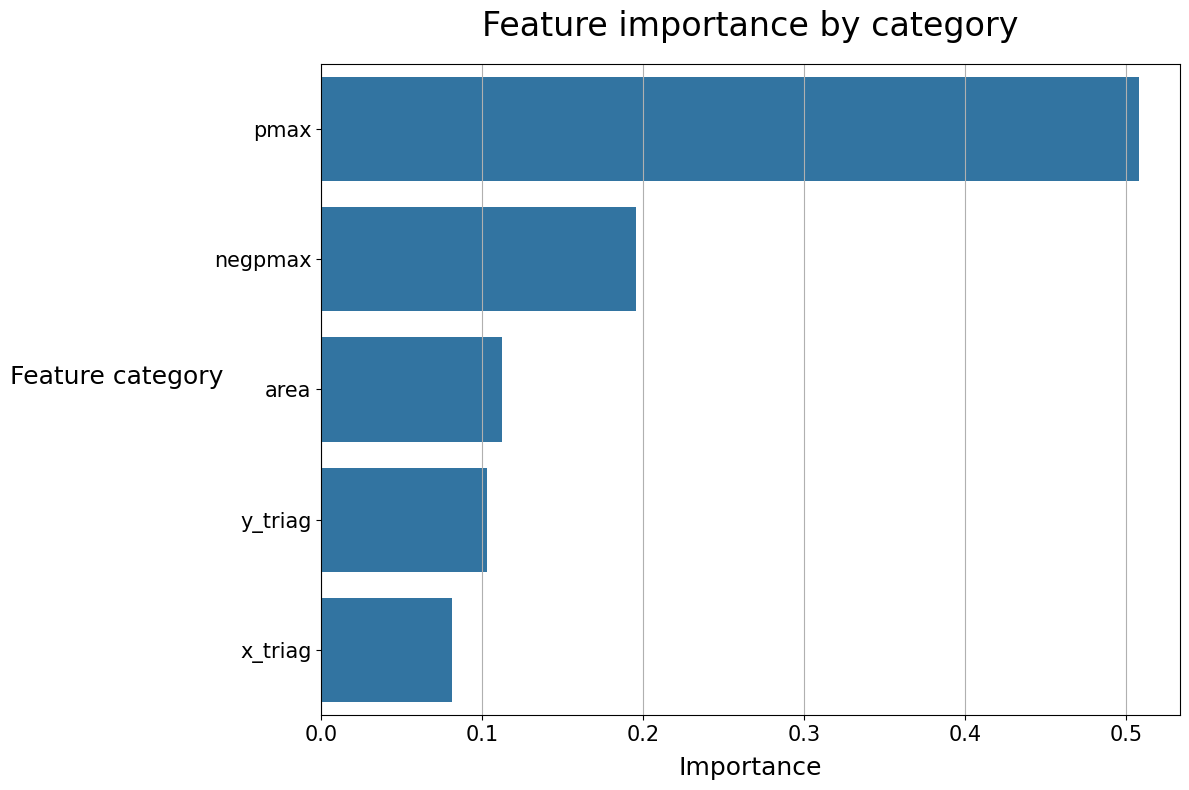

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Figure size 640x480 with 0 Axes>

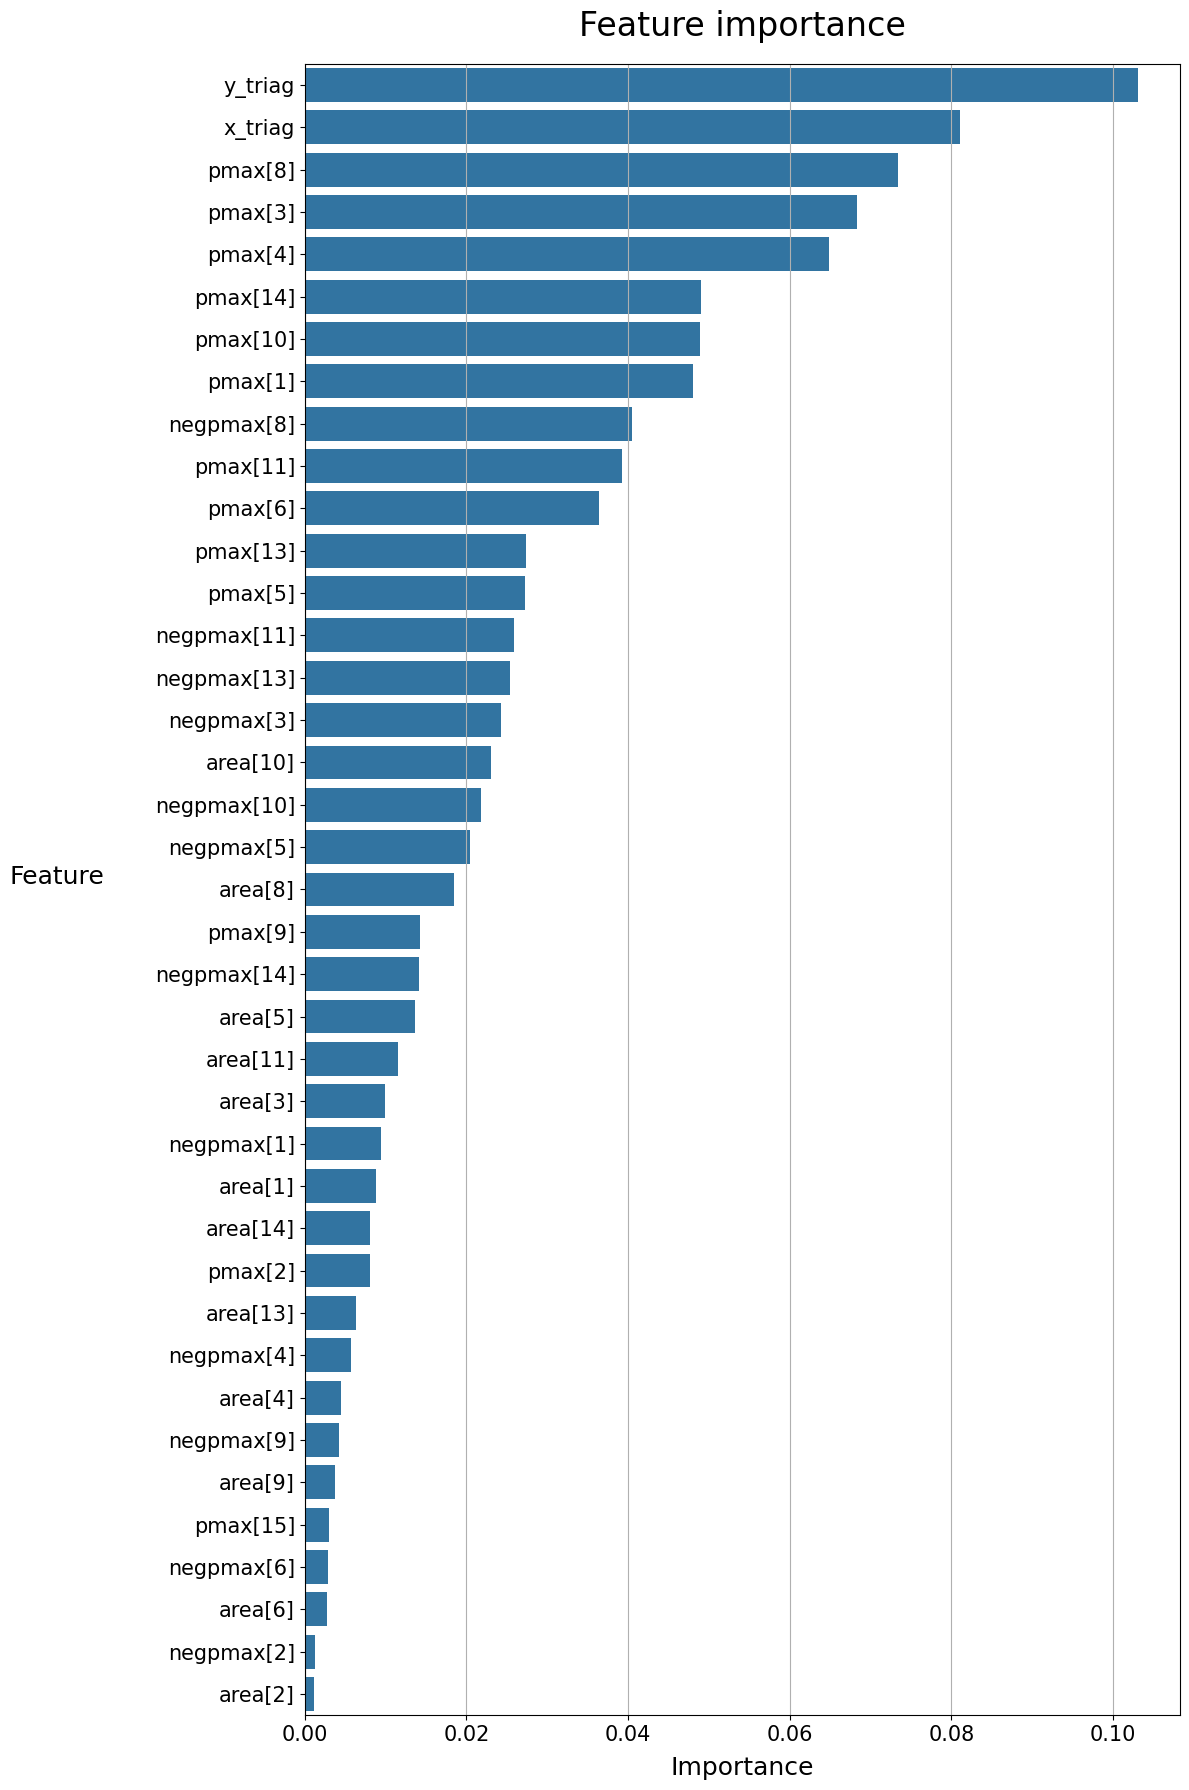

,negpmax[1],pmax[1],area[1],negpmax[2],pmax[2],area[2],negpmax[3],pmax[3],area[3],negpmax[4],...,norm_pmax[3],norm_pmax[4],norm_pmax[5],norm_pmax[6],norm_pmax[8],norm_pmax[9],norm_pmax[10],norm_pmax[11],norm_pmax[13],norm_pmax[14]
0,-18.004425,5.471771,3.643848,-22.761340,4.032864,2.640619,-18.937384,5.331083,4.710352,-19.290637,...,0.013490,0.013570,0.047259,0.031538,0.174973,0.133271,0.153403,0.033123,0.032076,0.015554
1,-4.803259,4.503870,2.298923,-5.131177,4.750781,3.820127,-3.100845,4.934006,7.685446,-3.141180,...,0.011157,0.018260,0.046555,0.026996,0.157759,0.123103,0.127424,0.055745,0.055087,0.032292
2,-4.371970,6.158609,5.045538,-5.405676,4.538477,2.966450,-4.156926,4.963304,3.264362,-4.267212,...,0.013146,0.014601,0.052159,0.032100,0.167615,0.139924,0.141420,0.025039,0.030429,0.015328
3,-6.397491,4.702301,3.457428,-5.796689,5.234012,3.301958,-4.153763,5.048691,9.449799,-5.541275,...,0.012272,0.013893,0.050946,0.027197,0.179703,0.133668,0.149581,0.026236,0.028765,0.012237
4,-5.572822,3.249487,1.648608,-3.710858,6.172155,13.262363,-5.367383,5.249942,5.879963,-3.921161,...,0.014510,0.020092,0.054625,0.026707,0.163405,0.145683,0.151683,0.022830,0.023319,0.013946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77095,-30.026776,56.954608,27.293333,-29.086530,57.684955,28.556666,-37.974728,57.511081,32.031767,-4.129938,...,0.149507,0.031990,0.025898,0.014119,0.015184,0.012714,0.012294,0.013123,0.050011,0.023909
77096,-30.444806,56.129352,28.125919,-29.846378,56.845700,27.527327,-38.512741,70.317703,32.093326,-3.588226,...,0.181623,0.028904,0.028167,0.012128,0.011945,0.010998,0.012194,0.017218,0.048905,0.026293
77097,-32.381271,57.420853,26.482062,-25.273895,55.481964,25.633240,-38.759097,69.291928,36.350563,-6.439026,...,0.177845,0.031212,0.033266,0.011318,0.015757,0.009434,0.013735,0.014015,0.047035,0.024222
77098,-28.282297,59.439566,31.095017,-29.513022,54.863931,26.981749,-32.774609,65.447589,31.707770,-6.075847,...,0.171794,0.026356,0.031019,0.014834,0.014183,0.011531,0.022302,0.017658,0.050212,0.019649


In [52]:
def analyse_feature_importante(
    forest: RandomForestRegressor, features_names: list[str]
):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    feature_import_df = pd.DataFrame(
        {
            "feature": features_names,
            "importance": importances,
        }
    )
    feature_import_df = feature_import_df.sort_values("importance", ascending=False)
    print(feature_import_df)

    # groupying by type of feature
    feature_cat_import_df = pd.DataFrame(
        {
            "feature": [re.sub(r"\[\d+\]", "", feat) for feat in features_names],
            "importance": importances,
        }
    )
    feature_cat_import_df = (
        feature_cat_import_df.groupby("feature", as_index=False)
        .sum()
        .sort_values("importance", ascending=False)
    )
    print(feature_cat_import_df)
    feature_import_df["std"] = std
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    plt.grid()
    plot = sns.barplot(
        feature_cat_import_df,
        y="feature",
        x="importance",
        color=sns.color_palette()[0],
        ax=ax,
    )
    personalize_barplot(
        ax,
        fig,
        feature_cat_import_df,
        "Feature importance by category",
        "Importance",
        "Feature category",
    )
    plt.show()
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    plt.grid()
    plot = sns.barplot(
        feature_import_df,
        y="feature",
        x="importance",
        color=sns.color_palette()[0],
        ax=ax,
    )
    personalize_barplot(
        ax,
        fig,
        feature_import_df,
        "Feature importance",
        "Importance",
        "Feature",
        12,
        18,
    )
    plt.show()



def personalize_barplot(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str,
    width_inches: int = 12,
    height_inches: int = 8,
) -> None:
    fig.set_size_inches(width_inches, height_inches)

    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20,
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0, position="right")
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=70.0, position="top")
    ax.tick_params(
        axis="x",
        labelsize=15,
    )
    ax.tick_params(
        axis="y",
        labelsize=15,
    )
    plt.tight_layout()


    
analyse_feature_importante(
    regr,  list(train_dataset.drop(["x", "y", "triangle"], axis = 1).columns)
)

# Check x,y divided by points

In [14]:
def generate_triangles_position_and_apply(
    dev_df: pd.DataFrame,
) -> dict[int, list[float]]:
    col_pads_pmax = [f"pmax[{pad}]" for pad in COL_PADS]

    cols = ["x", "y"] + col_pads_pmax

    dev_df["triangle"] = dev_df[cols].apply(define_triangle, axis=1)
    triangle_to_xy = (
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean()
    )

    triangle_to_xy_dict = {
        triangle: [
            triangle_to_xy.loc[triangle, :]["x"],
            triangle_to_xy.loc[triangle, :]["y"],
        ]
        for triangle in list(triangle_to_xy.index)
    }

    dev_df["x_triag"] = dev_df.apply(
        lambda x: get_x_triangle(x, triangle_to_xy_dict), axis=1
    )
    dev_df["y_triag"] = dev_df.apply(
        lambda x: get_y_triangle(x, triangle_to_xy_dict), axis=1
    )
    return triangle_to_xy_dict


def feature_extraction(
    data: pd.DataFrame, triangle_to_xy: dict[int, list[float]]
) -> None:
    cols = [f"pmax[{pad}]" for pad in COL_PADS]
    data["triangle"] = data[cols].apply(define_triangle, axis=1)
    print("Unique triangles eval:")
    print(np.unique(data["triangle"]))
    data["x_triag"] = data.apply(lambda x: get_x_triangle(x, triangle_to_xy), axis=1)
    data["y_triag"] = data.apply(lambda x: get_y_triangle(x, triangle_to_xy), axis=1)


def define_triangle(row: pd.Series):
    max_val = 0
    key_max = frozenset([6, 5, 4])
    for key in MAP_SET_PADS_TO_TRIANGLE:
        cols_to_select = [f"pmax[{pas}]" for pas in key]
        val = row[cols_to_select].mean()
        if val > max_val:
            max_val = val
            key_max = key

    return MAP_SET_PADS_TO_TRIANGLE[key_max]


def get_x_triangle(row: pd.Series, triangle_to_xy_dict: dict[int, list[float]]):
    return triangle_to_xy_dict[int(row["triangle"])][0]


def get_y_triangle(row: pd.Series, triangle_to_xy_dict: dict[int, list[float]]):
    return triangle_to_xy_dict[int(row["triangle"])][1]

train_dataset, test_dataset = test_train_set_points_div(dev_df_proc, ratio_train = 0.8)

triangle_to_xy: dict[int, list[float]] = generate_triangles_position_and_apply(
   train_dataset
)
print(triangle_to_xy)
feature_extraction(test_dataset, triangle_to_xy)
test_dataset["triangle"]

from IPython.display import Audio
sound_file = './beep.wav'
Audio(sound_file, autoplay=True)

(385500, 39)
(308400, 39)
(77100, 39)


C:\Users\cucch\AppData\Local\Temp\ipykernel_9784\616255793.py:11: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(


{1: [258.7233079985523, 564.8998672940041], 2: [382.22088334800947, 566.7641470083886], 3: [530.0, 590.0], 4: [570.275926128292, 576.0343131898153], 5: [235.87677468299555, 489.0078031863011], 6: [432.16719353705656, 492.67171184979406], 7: [546.1111504550122, 490.02071456393185], 8: [264.54911313161426, 387.70740795945744], 9: [378.87973664959765, 389.83174835406], 10: [568.2040627885503, 389.323460473045], 11: [238.66565522472976, 267.6607244452873], 12: [426.876419145253, 274.31970953890425], 13: [561.7178474811727, 280.73700372888794], 14: [339.7160934458144, 215.51427644386763]}
Unique triangles eval:
[ 1  2  4  5  6  7  8  9 10 11 12 13 14]


In [19]:
feature_extraction(eval_df_processed, triangle_to_xy)
print(eval_df_processed["triangle"])
eval_df_processed.to_csv("./eval_procc_triangle_v2.csv", index=False)

from IPython.display import Audio
sound_file = './beep.wav'
Audio(sound_file, autoplay=True)

0         12
1          7
2          8
3          7
4          9
          ..
128495    12
128496    11
128497     2
128498     8
128499    12
Name: triangle, Length: 128500, dtype: int64


In [17]:
train_dataset.to_csv("./train_dataset_triangle.csv", index=False)
test_dataset.to_csv("./test_dataset_triangle.csv", index=False)
filename = 'triangle_to_xy.sav'
pickle.dump(triangle_to_xy, open(filename, 'wb'))


In [25]:
print(test_dataset.shape)
print(train_dataset.shape)
print(eval_df_processed.shape)
print(test_dataset.columns)
print(train_dataset.columns)
print(eval_df_processed.columns)

(77100, 42)
(308400, 42)
(128500, 40)
Index(['x', 'y', 'negpmax[1]', 'pmax[1]', 'area[1]', 'negpmax[2]', 'pmax[2]',
       'area[2]', 'negpmax[3]', 'pmax[3]', 'area[3]', 'negpmax[4]', 'pmax[4]',
       'area[4]', 'negpmax[5]', 'pmax[5]', 'area[5]', 'negpmax[6]', 'pmax[6]',
       'area[6]', 'negpmax[8]', 'pmax[8]', 'area[8]', 'negpmax[9]', 'pmax[9]',
       'area[9]', 'negpmax[10]', 'pmax[10]', 'area[10]', 'negpmax[11]',
       'pmax[11]', 'area[11]', 'negpmax[13]', 'pmax[13]', 'area[13]',
       'negpmax[14]', 'pmax[14]', 'area[14]', 'pmax[15]', 'triangle',
       'x_triag', 'y_triag'],
      dtype='object')
Index(['x', 'y', 'negpmax[1]', 'pmax[1]', 'area[1]', 'negpmax[2]', 'pmax[2]',
       'area[2]', 'negpmax[3]', 'pmax[3]', 'area[3]', 'negpmax[4]', 'pmax[4]',
       'area[4]', 'negpmax[5]', 'pmax[5]', 'area[5]', 'negpmax[6]', 'pmax[6]',
       'area[6]', 'negpmax[8]', 'pmax[8]', 'area[8]', 'negpmax[9]', 'pmax[9]',
       'area[9]', 'negpmax[10]', 'pmax[10]', 'area[10]', 'negpmax[11

# KNN Regressor

In [34]:
y_train = train_dataset[["x", "y"]]
X_train = train_dataset.drop(["x", "y"], axis=1)
y_val = test_dataset[["x", "y"]]
X_val = test_dataset.drop(["x", "y"], axis=1)

start_time = datetime.datetime.now().replace(microsecond=0)
regr = make_pipeline(StandardScaler(), PCA(0.95), KNeighborsRegressor(n_jobs = -1, weights="distance"))
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

print("Normalized by maxpmax:")
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)
    

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Normalized by maxpmax:
7.212364355147929
Time for the computations:
0:00:57
